# Detecting and Handling Covariates in Data

Data taken from: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

**Reason for not using the already present datasets:**

- According to [issue #3](https://github.com/mozilla/PRESC/issues/3) the solutions on `eeg.csv` and `vehicles.csv` do not show a significant change in the evaluation metrics when the ratio chosen to split the data is changed. For example, let us consider `vehicles.csv`, the following are the results explaining the variation in the evaluation metric when train-test splitting ratio is changed:
<img src='data/Capture1.PNG'>
    
    - As we can see that the variation is not very significant
    
- In the already available datasets the choice of train-test split was not affecting model performance to a great extent.
- So we need a dataset which is more complicated. This data set based on predicting the probability that an auto insurance policy holder files a claim by Porto Seguro has data which has covariate shift. So the model's performance will highly degrade on choosing just any random train-test split ratio.

- Using the [previous algorithm](https://github.com/mozilla/PRESC/blob/0785213e5c65e6f799c3df829602f3c624a53c4b/dev/Sidrah-Madiha/Traversal_of_the_space_of_train_test_splits/vehicles_dataset_classifer_for_testing_issue%233.ipynb) as used to predict on `vehicles.csv` the following result is obtained:
<img src='data/Capture2.PNG'>
<img src='data/Capture3.PNG'>


**The approach used does the following:**
1. Fetch data
2. Add a column to describe if the data point belongs to train data or not
3. Combine train and test data
4. Building RandomForestClassifier
5. Using StratifiedKFold to perform train-test split
6. Predicting the probability of a data point from the entire data set belonging to train (calculating covariance)
7. Improving performance by assigning importance weight using Density Ratio Estimation
8. Using the above weights, running RandomForestClassifier again

## Step 1: Data Fetching and Pre-Processing

In [1]:
# importing necessary libraries
import os
import requests
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
warnings.filterwarnings("ignore")

# downloading data
def extract_data(file_name, file_path):
    !kaggle competitions download porto-seguro-safe-driver-prediction -f $file_name -p $file_path --force

train = 'train.csv'
test = 'test.csv'

raw_data_path = os.path.join('../../datasets', 'safe-driver', 'raw')
extract_data(train, raw_data_path)
extract_data(test, raw_data_path)

# extracting train data
from zipfile import ZipFile
zf = ZipFile('../../datasets/safe-driver/raw/train.csv.zip', 'r')
zf.extractall('../../datasets/safe-driver')
zf.close()

# extracting test data
zf = ZipFile('../../datasets/safe-driver/raw/test.csv.zip', 'r')
zf.extractall('../../datasets/safe-driver')
zf.close()

# loading data
train = pd.read_csv('../../datasets/safe-driver/train.csv', index_col='id')
test = pd.read_csv('../../datasets/safe-driver/test.csv', index_col='id')


  0%|          | 0.00/30.0M [00:00<?, ?B/s]
  3%|3         | 1.00M/30.0M [00:01<00:42, 722kB/s]
  7%|6         | 2.00M/30.0M [00:02<00:33, 887kB/s]
 10%|#         | 3.00M/30.0M [00:02<00:27, 1.04MB/s]
 13%|#3        | 4.00M/30.0M [00:03<00:21, 1.24MB/s]
 17%|#6        | 5.00M/30.0M [00:03<00:20, 1.27MB/s]
 20%|##        | 6.00M/30.0M [00:04<00:21, 1.17MB/s]
 23%|##3       | 7.00M/30.0M [00:05<00:21, 1.11MB/s]
 27%|##6       | 8.00M/30.0M [00:06<00:20, 1.13MB/s]
 30%|###       | 9.00M/30.0M [00:07<00:17, 1.27MB/s]
 33%|###3      | 10.0M/30.0M [00:08<00:15, 1.38MB/s]
 37%|###6      | 11.0M/30.0M [00:08<00:14, 1.37MB/s]
 40%|####      | 12.0M/30.0M [00:09<00:11, 1.68MB/s]
 43%|####3     | 13.0M/30.0M [00:09<00:09, 1.92MB/s]
 47%|####6     | 14.0M/30.0M [00:09<00:07, 2.16MB/s]
 50%|#####     | 15.0M/30.0M [00:10<00:06, 2.30MB/s]
 53%|#####3    | 16.0M/30.0M [00:10<00:05, 2.59MB/s]
 57%|#####6    | 17.0M/30.0M [00:10<00:04, 2.86MB/s]
 60%|######    | 18.0M/30.0M [00:11<00:04, 2.99MB/s]
 63


  0%|          | 0.00/44.4M [00:00<?, ?B/s]
  2%|2         | 1.00M/44.4M [00:00<00:25, 1.76MB/s]
  5%|4         | 2.00M/44.4M [00:01<00:23, 1.87MB/s]
  7%|6         | 3.00M/44.4M [00:01<00:21, 1.98MB/s]
  9%|9         | 4.00M/44.4M [00:01<00:19, 2.16MB/s]
 11%|#1        | 5.00M/44.4M [00:02<00:21, 1.96MB/s]
 14%|#3        | 6.00M/44.4M [00:02<00:19, 2.11MB/s]
 16%|#5        | 7.00M/44.4M [00:03<00:17, 2.28MB/s]
 18%|#8        | 8.00M/44.4M [00:03<00:16, 2.34MB/s]
 20%|##        | 9.00M/44.4M [00:04<00:15, 2.40MB/s]
 23%|##2       | 10.0M/44.4M [00:04<00:14, 2.45MB/s]
 25%|##4       | 11.0M/44.4M [00:05<00:15, 2.31MB/s]
 27%|##7       | 12.0M/44.4M [00:06<00:20, 1.69MB/s]
 29%|##9       | 13.0M/44.4M [00:07<00:25, 1.30MB/s]
 32%|###1      | 14.0M/44.4M [00:08<00:25, 1.24MB/s]
 34%|###3      | 15.0M/44.4M [00:08<00:22, 1.34MB/s]
 36%|###6      | 16.0M/44.4M [00:09<00:22, 1.30MB/s]
 38%|###8      | 17.0M/44.4M [00:10<00:21, 1.31MB/s]
 41%|####      | 18.0M/44.4M [00:11<00:23, 1.16MB/s]
 

In [2]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


## Step 2: Indicator for Source of Origin
Adding a feature ‘is_train’ in both train and test data. Value for this feature will be 0 for test and 1 for train.

In [4]:
# adding a coulmn to test and train set that tells if the data point belongs to either

# data point does not belong to train
test['is_train'] = 0
# data point belongs to train
train['is_train'] = 1

## Step 3: Combining train and test
Combining both the datasets. Also since train data has the original ‘target’ variable which is not present in test, we have to drop that variable too.

In [5]:
# combining train, test
df_combine = pd.concat([train, test], axis=0, ignore_index=True)

# dropping ‘target’ column as it is not present in the test
df_combine = df_combine.drop('target', axis =1)

y = df_combine['is_train'].values #labels
x = df_combine.drop('is_train', axis=1).values #covariates or our independent variables
tst, trn = test.values, train.values

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Step 4: Building and Testing a Classifier
Random Forest Classifier is used to predict the labels for each row in the combined dataset.

In [6]:
# Building and testing a classifier
rfc = RandomForestClassifier(n_jobs=3, max_depth=5, min_samples_leaf = 5)

#creating an empty prediction array
predictions = np.zeros(y.shape) 

## Step 5: Performing Train-Test Split
We are using stratified 4 fold to ensure that percentage for each class is preserved and we cover the whole data once. For each row the classifier will calculate the probability of it belonging to train.

In [7]:
# initializing model
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_test)[:, 1] #calculating the probability
    predictions[test_idx] = probs

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Step 6: Interpreting the Results
If the classifier is able to classify the rows into train and test with good accuracy, our AUC score should be on the higher side (greater than 0.8). This implies strong covariate shift between train and test.

In [8]:
print('ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))

ROC-AUC: 0.5007147418638885


#### Inference: AUC value of 0.49 implies that there is no evidence of strong covariate shift. This means that majority of the observations comes from a feature space which is not specific to test or train.

## Step 7: Improving Performance
1. Dropping of drifting features
    - Note: This method is applicable to the situation where you witness covariate shift.
    - Extract feature importance from the random forest classifier object that we have built in the previous section
    - The top features are the ones which are drifting and causing the shift.
    - Drop those features one by one and compute the model performance
2. Importance weight using Density Ratio Estimation
    - Note: This method is applicable irrespective of whether there exist a covariate shift or not.

#### Let’s look at the predictions that we have calculated in the previous section. For each observation, this prediction tells us the probability that it belongs to the training data according to our classifier.

In [9]:
predictions[:10]

array([0.39914871, 0.40063592, 0.40234769, 0.40055795, 0.39907569,
       0.40114795, 0.39854171, 0.40007704, 0.39976834, 0.39438289])

For each row of training data we calculate a coefficient `w = P(test)/P(train)`.
This `w` tells us how close is the observation from the training data to our test data.
#### We can use this w as sample weights in any of our classifier to increase the weight of these observation which seems similar to our test data. Intuitively this makes sense as our model will focus more on capturing patterns from the observations which seems similar to our test.

In [10]:
predictions.shape

(1488028,)

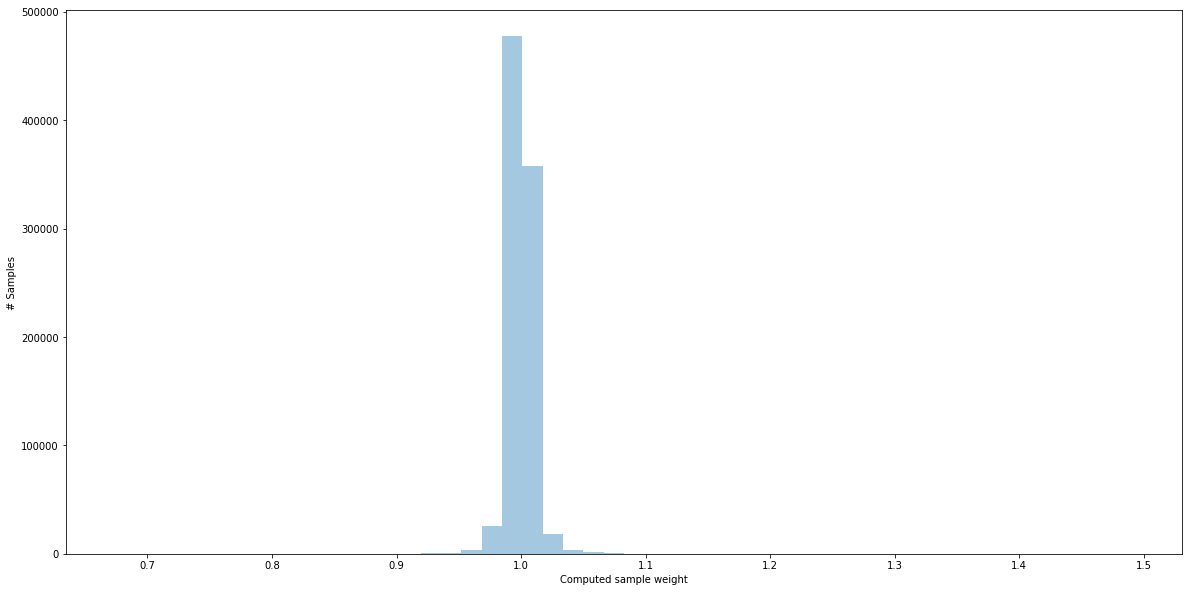

In [11]:
plt.figure(figsize=(20,10))
predictions_train = predictions[:len(tst)]  # filtering the actual training rows
weights = (1./predictions_train) - 1. 
weights /= np.mean(weights) # Normalizing the weights

plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.distplot(weights, kde=False)

#### Inference:
- Higher the weight for the observation, more is it similar to the test data
- Almost 70% of training samples have sample weight of close to 1 and hence comes from a feature space which is not very specific to train or test high density region. This is in line with the AUC value that we have calculated

## Step 8: Passing the Weights Calculated in the Model Fit Method 

In [12]:
# instantiating model
m = RandomForestClassifier(n_jobs=3, 
                           min_samples_split= 13, 
                            n_estimators = 300,
                            max_depth= 10,
                            max_features= 13
                          )

# splitting train and test data
train_x = train.drop('target', axis=1)
train_y = train.target
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state = 42, stratify=train_y)

# fitting on train data
m.fit(X_train, y_train, sample_weight=weights[:len(X_train)])

# predicting on test data
y_pred = m.predict(X_test)

# calculating classification report
eval_report = classification_report(y_test, y_pred)
print(eval_report)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print(cnf_matrix)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    143380
           1       0.38      0.00      0.00      5423

   micro avg       0.96      0.96      0.96    148803
   macro avg       0.67      0.50      0.49    148803
weighted avg       0.94      0.96      0.95    148803

[[143375      5]
 [  5420      3]]


We can see the very significant improvement in f1-score which now is 0.96 and was 0.52 using the regular methods